**MULTIPLE LINEAR REGRESSION MODEL FOR WEIGHT ESTIMATION FROM MEASUREMENTS OF THE FISH**

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

**1. UNDERSTANDING THE DATASET**

In [2]:
data = pd.read_csv('Fish.csv')
df = data.copy()
df.sample(10)

,Species,Weight,Length1,Length2,Length3,Height,Width
27,Bream,714.0,32.7,36.0,41.5,16.5170,5.8515
114,Perch,700.0,34.5,37.0,39.4,10.8350,6.2646
99,Perch,180.0,23.0,25.0,26.5,6.4395,3.6835
41,Roach,110.0,19.1,20.8,23.1,6.1677,3.3957
16,Bream,700.0,30.4,33.0,38.3,14.8604,5.2854
123,Perch,1100.0,39.0,42.0,44.6,12.8002,6.8684
84,Perch,125.0,19.0,21.0,22.5,5.6925,3.6675
125,Perch,1100.0,40.1,43.0,45.5,12.5125,7.4165
35,Roach,40.0,12.9,14.1,16.2,4.1472,2.2680
15,Bream,600.0,29.4,32.0,37.2,15.4380,5.5800


**Meanings of the Columns:**
* Species: Species name of fish
* Weight: Weight of fish in gram
* Length1: Vertical length in cm
* Length2: Diagonal length in cm
* Length3: Cross length in cm
* Height: Height in cm
* Width: Diagonal width in cm

Our dependent variable is 'Weight'. Independent variables are 'species', different lengths, 'height' and 'width'.

I will use independent variables (measurements of the fish) to estimate dependent variable (weight of the fish). 

**Changing the Column Names:**

In [4]:
df.rename(columns= {'Length1':'LengthVer', 'Length2':'LengthDia', 'Length3':'LengthCro'}, inplace=True)
df.head()

,Species,Weight,LengthVer,LengthDia,LengthCro,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Species    159 non-null    object 
 1   Weight     159 non-null    float64
 2   LengthVer  159 non-null    float64
 3   LengthDia  159 non-null    float64
 4   LengthCro  159 non-null    float64
 5   Height     159 non-null    float64
 6   Width      159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


**Investigating Missing Values:**

In [6]:
print(str('Is there any NaN value in the dataset: '), df.isnull().values.any())

Is there any NaN value in the dataset:  False


**Different Species and Their Counts:**

In [7]:
sp = df['Species'].value_counts()
sp = pd.DataFrame(sp)
sp.T

Species,Perch,Bream,Roach,Pike,Smelt,Parkki,Whitefish
count,56,35,20,17,14,11,6


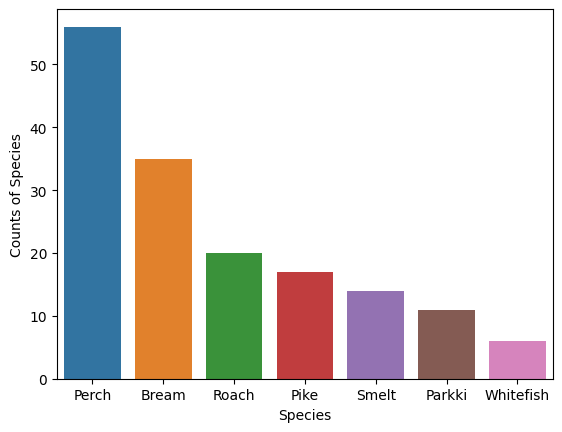

In [11]:
sns.barplot(x=sp.index, y=sp['count']);
plt.xlabel('Species')
plt.ylabel('Counts of Species')
plt.show()

**Correlation of the Variables:**

In [14]:
df.select_dtypes('number').corr()

,Weight,LengthVer,LengthDia,LengthCro,Height,Width
Weight,1.000000,0.915712,0.918618,0.923044,0.724345,0.886507
LengthVer,0.915712,1.000000,0.999517,0.992031,0.625378,0.867050
LengthDia,0.918618,0.999517,1.000000,0.994103,0.640441,0.873547
LengthCro,0.923044,0.992031,0.994103,1.000000,0.703409,0.878520
Height,0.724345,0.625378,0.640441,0.703409,1.000000,0.792881
Width,0.886507,0.867050,0.873547,0.878520,0.792881,1.000000


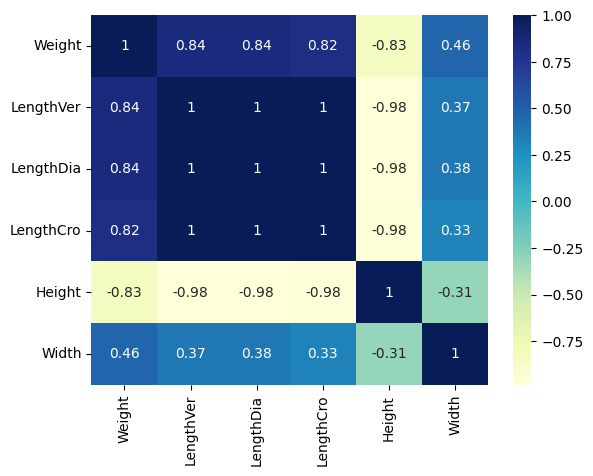

In [15]:
sns.heatmap(df.select_dtypes('number').corr().corr(), annot=True, cmap='YlGnBu');

/Users/saikiran/Documents/GitHub/venkata_lab4/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


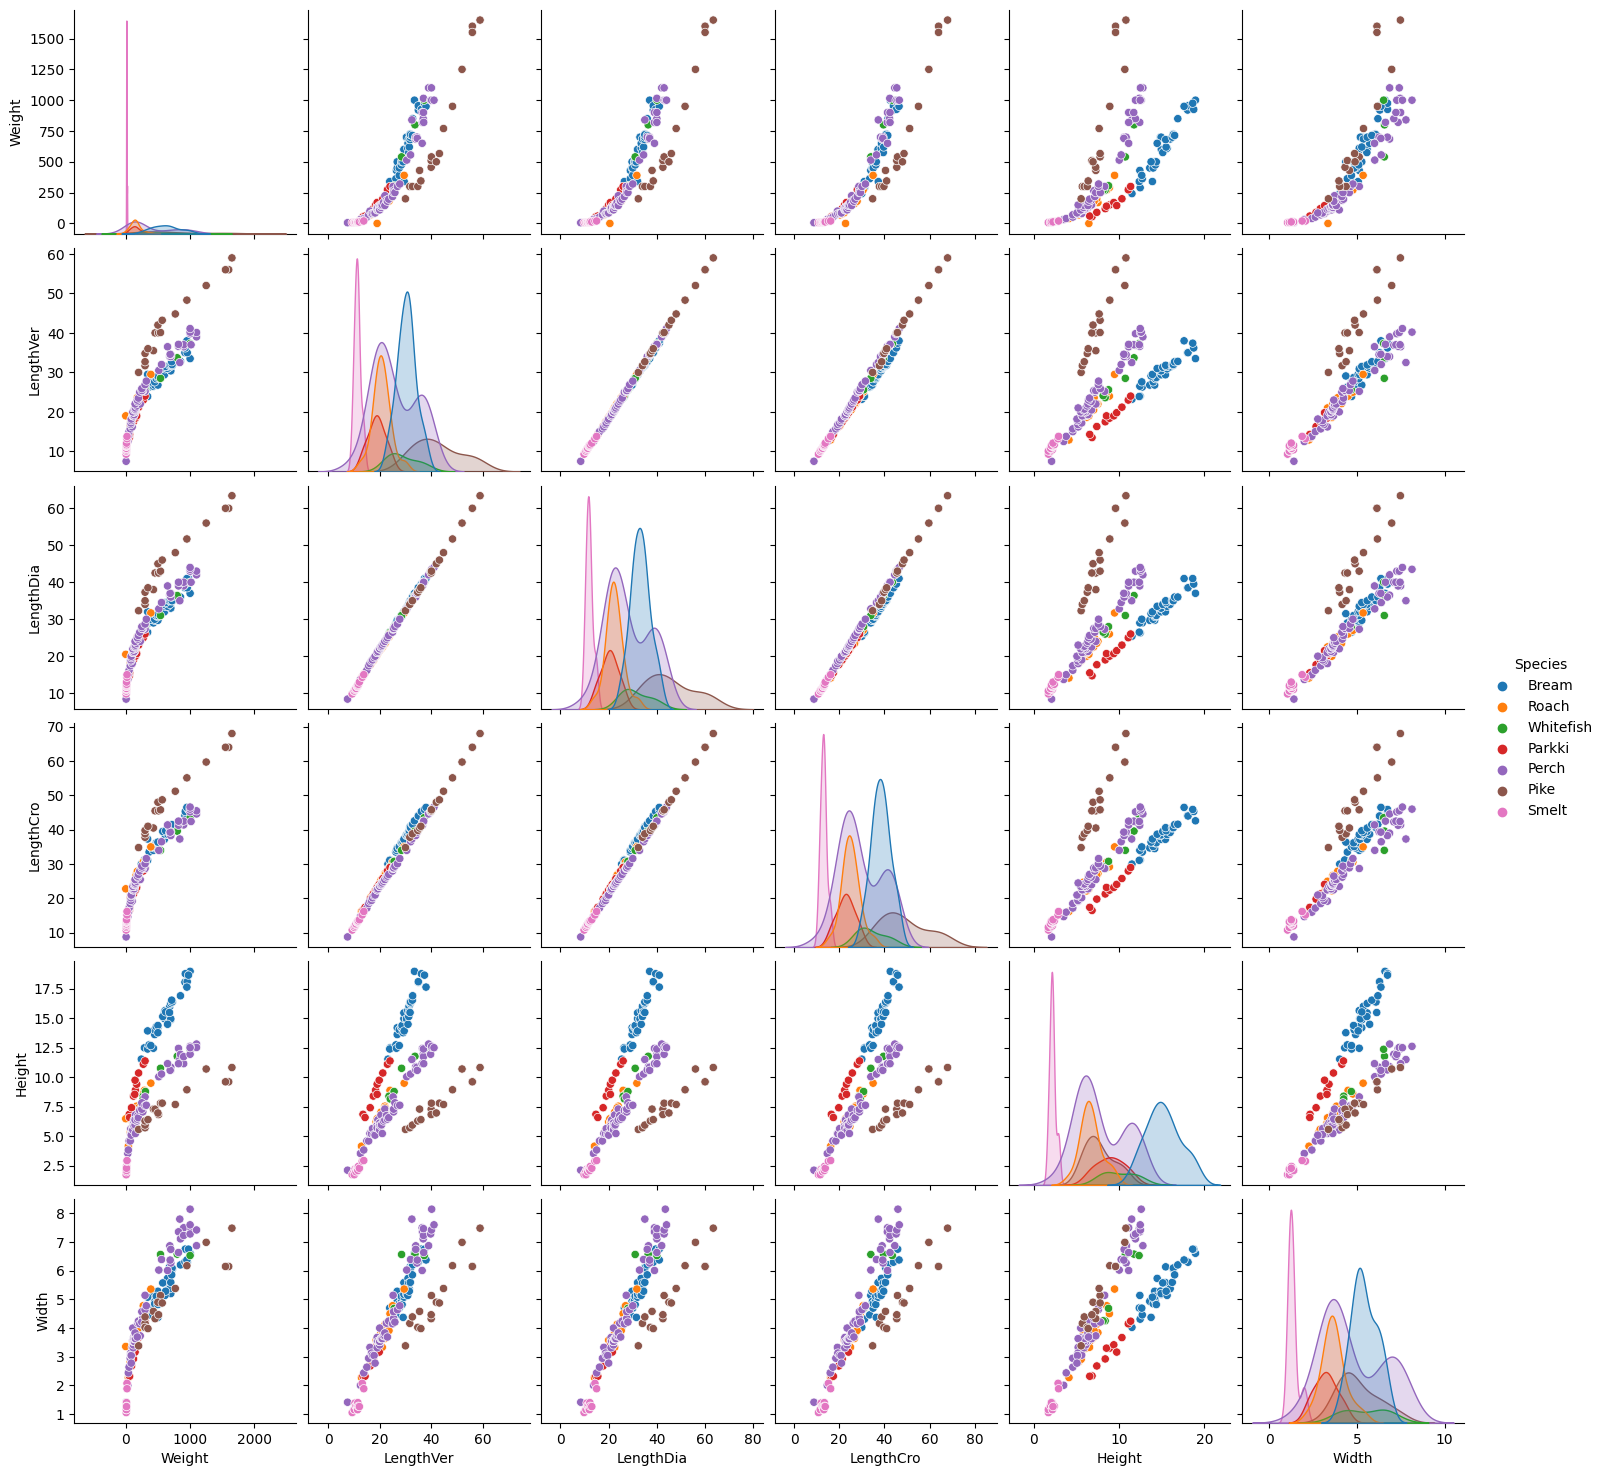

In [16]:
g = sns.pairplot(df, kind='scatter', hue='Species');

**Basic Statistics of the Dataset:**

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Weight,159.0,398.326415,357.978317,0.0000,120.00000,273.0000,650.0000,1650.000
LengthVer,159.0,26.247170,9.996441,7.5000,19.05000,25.2000,32.7000,59.000
LengthDia,159.0,28.415723,10.716328,8.4000,21.00000,27.3000,35.5000,63.400
LengthCro,159.0,31.227044,11.610246,8.8000,23.15000,29.4000,39.6500,68.000
Height,159.0,8.970994,4.286208,1.7284,5.94480,7.7860,12.3659,18.957
Width,159.0,4.417486,1.685804,1.0476,3.38565,4.2485,5.5845,8.142


**Analysing and Dealing with Outliers**

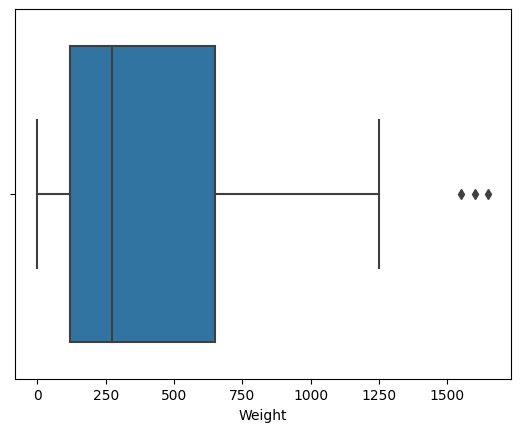

In [18]:
sns.boxplot(x=df['Weight']);

In [19]:
dfw = df['Weight']
dfw_Q1 = dfw.quantile(0.25)
dfw_Q3 = dfw.quantile(0.75)
dfw_IQR = dfw_Q3 - dfw_Q1
dfw_lowerend = dfw_Q1 - (1.5 * dfw_IQR)
dfw_upperend = dfw_Q3 + (1.5 * dfw_IQR)

In [20]:
dfw_outliers = dfw[(dfw < dfw_lowerend) | (dfw > dfw_upperend)]
dfw_outliers

142    1600.0
143    1550.0
144    1650.0
Name: Weight, dtype: float64

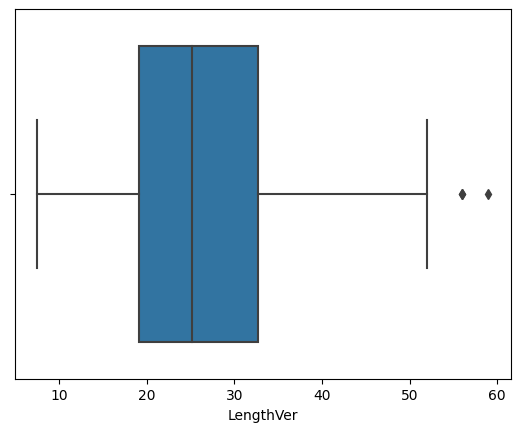

In [21]:
sns.boxplot(x=df['LengthVer']);

In [22]:
dflv = df['LengthVer']
dflv_Q1 = dflv.quantile(0.25)
dflv_Q3 = dflv.quantile(0.75)
dflv_IQR = dflv_Q3 - dflv_Q1
dflv_lowerend = dflv_Q1 - (1.5 * dflv_IQR)
dflv_upperend = dflv_Q3 + (1.5 * dflv_IQR)

dflv_outliers = dflv[(dflv < dflv_lowerend) | (dflv > dflv_upperend)]
dflv_outliers

142    56.0
143    56.0
144    59.0
Name: LengthVer, dtype: float64

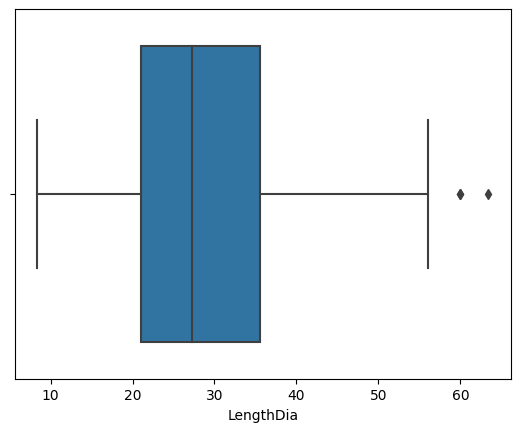

In [23]:
sns.boxplot(x=df['LengthDia']);

In [24]:
dfdia = df['LengthDia']
dfdia_Q1 = dfdia.quantile(0.25)
dfdia_Q3 = dfdia.quantile(0.75)
dfdia_IQR = dfdia_Q3 - dfdia_Q1
dfdia_lowerend = dfdia_Q1 - (1.5 * dfdia_IQR)
dfdia_upperend = dfdia_Q3 + (1.5 * dfdia_IQR)

dfdia_outliers = dfdia[(dfdia < dfdia_lowerend) | (dfdia > dfdia_upperend)]
dfdia_outliers

142    60.0
143    60.0
144    63.4
Name: LengthDia, dtype: float64

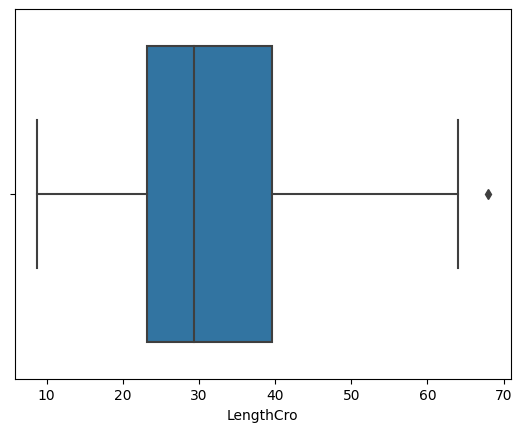

In [25]:
sns.boxplot(x=df['LengthCro']);

In [26]:
dfcro = df['LengthCro']
dfcro_Q1 = dfcro.quantile(0.25)
dfcro_Q3 = dfcro.quantile(0.75)
dfcro_IQR = dfcro_Q3 - dfcro_Q1
dfcro_lowerend = dfcro_Q1 - (1.5 * dfcro_IQR)
dfcro_upperend = dfcro_Q3 + (1.5 * dfcro_IQR)

dfcro_outliers = dfcro[(dfcro < dfcro_lowerend) | (dfcro > dfcro_upperend)]
dfcro_outliers

144    68.0
Name: LengthCro, dtype: float64

**Outliers of the Dataset:**

In [27]:
df[142:145]

,Species,Weight,LengthVer,LengthDia,LengthCro,Height,Width
142,Pike,1600.0,56.0,60.0,64.0,9.600,6.144
143,Pike,1550.0,56.0,60.0,64.0,9.600,6.144
144,Pike,1650.0,59.0,63.4,68.0,10.812,7.480


In our dataset, index number 142, 143 and 144 are the outliers.

In this study I am going to erase these 3 data entries from my dataset.

**Reanalysing Basic Statistics After Eliminating Outliers**

In [28]:
df1 = df.drop([142,143,144])
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Weight,156.0,375.217308,319.546978,0.0000,120.000000,271.0000,612.500000,1250.000
LengthVer,156.0,25.655769,9.119630,7.5000,19.000000,25.0000,32.125000,52.000
LengthDia,156.0,27.786538,9.792651,8.4000,21.000000,26.7500,35.000000,56.000
LengthCro,156.0,30.571154,10.695359,8.8000,23.025000,29.2500,39.425000,59.700
Height,156.0,8.951128,4.324325,1.7284,5.931675,7.6478,12.378550,18.957
Width,156.0,4.375719,1.672188,1.0476,3.369600,4.2433,5.424375,8.142


**2. PREPARING THE MACHINE LEARNING MODEL:**

**Separating Dependant and Independant Variables**

In [29]:
# Dependant (Target) Variable:
y = df1['Weight']
# Independant Variables:
X = df1.iloc[:,2:7]

**Dividing Dataset into Train and Test Datasets**

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [31]:
print('How many samples do we have in our test and train datasets?')
print('X_train: ', np.shape(X_train))
print('y_train: ', np.shape(y_train))
print('X_test: ', np.shape(X_test))
print('y_test: ', np.shape(y_test))

How many samples do we have in our test and train datasets?
X_train:  (124, 5)
y_train:  (124,)
X_test:  (32, 5)
y_test:  (32,)


**Multiple Linear Regression Formula:**

y = b0 + b1*X1 + b2*X2 + b3*X3 + ... + bn*Xn

y : Dependent variable

b0 : Constant

b1 - bn : Coefficients

X1 - Xn : Independent variables

**Sklearn Library Linear Regression Model:**

I will train my model by using training dataset.

In [32]:
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression()

**My Model's Linear Regression Formula:**

In [33]:
# My model's parameters:
print('Model intercept: ', reg.intercept_)
print('Model coefficients: ', reg.coef_)

Model intercept:  -441.00887253881695
Model coefficients:  [ 89.93843031 -32.68619524 -37.53063323  33.07275974  60.72005923]


In [34]:
print('y = ' + str('%.2f' % reg.intercept_) + ' + ' + str('%.2f' % reg.coef_[0]) + '*X1 ' + str('%.2f' % reg.coef_[1]) + '*X2 ' +
      str('%.2f' % reg.coef_[2]) + '*X3 + ' + str('%.2f' % reg.coef_[3]) + '*X4 + ' + str('%.2f' % reg.coef_[4]) + '*X5')

y = -441.01 + 89.94*X1 -32.69*X2 -37.53*X3 + 33.07*X4 + 60.72*X5


**3. PREDICTIONS BY USING THE MODEL**

**Predicting Weights from Train Dataset:**

In [35]:
y_head = reg.predict(X_train)

**Analysing the Success of the Model from Train Dataset and Predictions:**

In [36]:
r2_score(y_train, y_head)

0.9116039087262157

But if we change random_state our train and test samples will be different and our model's score will be different. 
In order to eliminate this change I will use cross validation:

In [37]:
from sklearn.model_selection import cross_val_score
cross_val_score_train = cross_val_score(reg, X_train, y_train, cv=10, scoring='r2')
print(cross_val_score_train)

[0.81965553 0.91733889 0.90970988 0.96003833 0.93655595 0.86878097
 0.91955783 0.8518532  0.84071059 0.81121078]


There are 10 different versions of r2 scores using my model (reg). If I get the average of this I can achieve cross validated r2 score of my training model:

In [38]:
cross_val_score_train.mean()

0.8835411966576624

**Using Trained Model and Test Dataset to Estimate Weights:**

In [39]:
y_pred = reg.predict(X_test)

**Analysing the Success of the Trained Model from Test Dataset and Predictions:**

In [40]:
print(r2_score(y_test, y_pred))

0.8671964388742471


**4. VISUALISATION OF THE PREDICTIONS:**

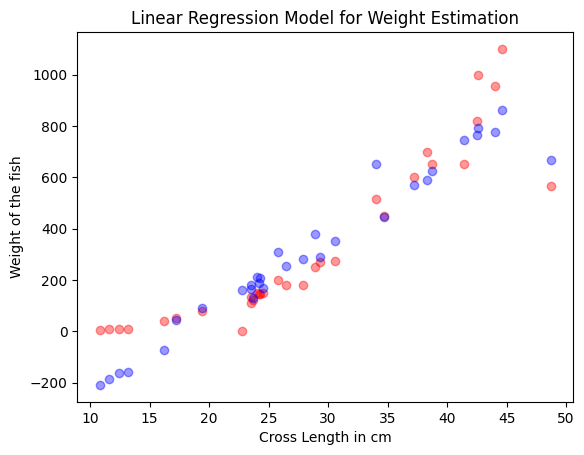

In [41]:
plt.scatter(X_test['LengthCro'], y_test, color='red', alpha=0.4)
plt.scatter(X_test['LengthCro'], y_pred, color='blue', alpha=0.4)
plt.xlabel('Cross Length in cm')
plt.ylabel('Weight of the fish')
plt.title('Linear Regression Model for Weight Estimation');

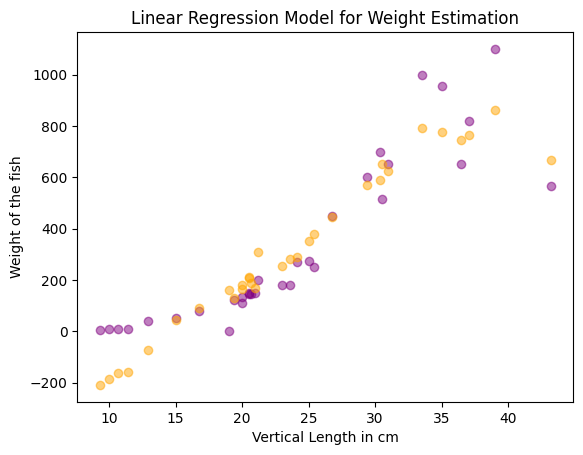

In [42]:
plt.scatter(X_test['LengthVer'], y_test, color='purple', alpha=0.5)
plt.scatter(X_test['LengthVer'], y_pred, color='orange', alpha=0.5)
plt.xlabel('Vertical Length in cm')
plt.ylabel('Weight of the fish')
plt.title('Linear Regression Model for Weight Estimation');

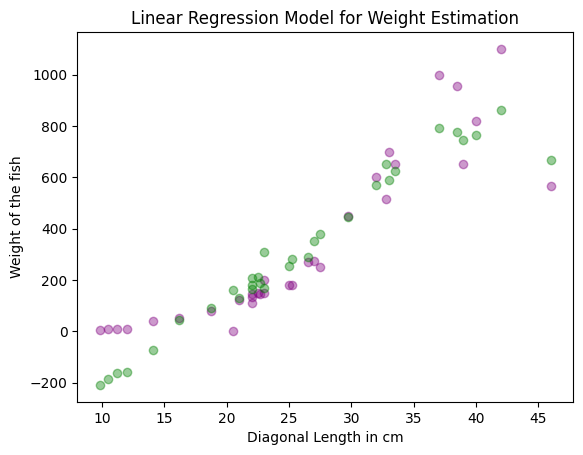

In [43]:
plt.scatter(X_test['LengthDia'], y_test, color='purple', alpha=0.4)
plt.scatter(X_test['LengthDia'], y_pred, color='green', alpha=0.4)
plt.xlabel('Diagonal Length in cm')
plt.ylabel('Weight of the fish')
plt.title('Linear Regression Model for Weight Estimation');

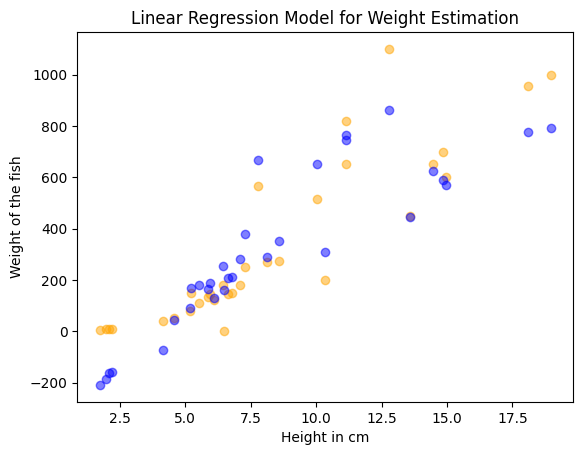

In [44]:
plt.scatter(X_test['Height'], y_test, color='orange', alpha=0.5)
plt.scatter(X_test['Height'], y_pred, color='blue', alpha=0.5)
plt.xlabel('Height in cm')
plt.ylabel('Weight of the fish')
plt.title('Linear Regression Model for Weight Estimation');

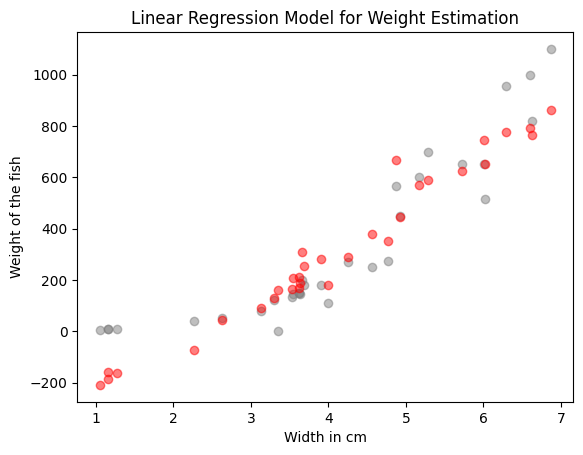

In [45]:
plt.scatter(X_test['Width'], y_test, color='gray', alpha=0.5)
plt.scatter(X_test['Width'], y_pred, color='red', alpha=0.5)
plt.xlabel('Width in cm')
plt.ylabel('Weight of the fish')
plt.title('Linear Regression Model for Weight Estimation');

**5. COMPARING REAL AND PREDICTED WEIGHTS**

In [46]:
y_pred1 = pd.DataFrame(y_pred, columns=['Estimated Weight'])
y_pred1.head()

,Estimated Weight
0,746.034615
1,44.698577
2,282.287266
3,777.208209
4,-74.802289


In [47]:
y_test1 = pd.DataFrame(y_test)
y_test1 = y_test1.reset_index(drop=True)
y_test1.head()

,Weight
0,650.0
1,51.5
2,180.0
3,955.0
4,40.0


In [48]:
ynew = pd.concat([y_test1, y_pred1], axis=1)
ynew

,Weight,Estimated Weight
0,650.0,746.034615
1,51.5,44.698577
2,180.0,282.287266
3,955.0,777.208209
4,40.0,-74.802289
5,0.0,159.717948
6,600.0,569.637735
7,514.0,651.097615
8,272.0,349.707917
9,9.8,-163.684074


In [56]:
X_test

,LengthVer,LengthDia,LengthCro,Height,Width
117,36.5,39.0,41.4,11.1366,6.0030
75,15.0,16.2,17.2,4.5924,2.6316
51,23.6,25.2,27.9,7.0866,3.9060
31,35.0,38.5,44.0,18.0840,6.2920
35,12.9,14.1,16.2,4.1472,2.2680
40,19.0,20.5,22.8,6.4752,3.3516
14,29.4,32.0,37.2,14.9544,5.1708
109,30.5,32.8,34.0,10.0300,6.0180
53,25.0,27.0,30.6,8.5680,4.7736
149,10.7,11.2,12.4,2.0832,1.2772


In [54]:
# Save the model to a .pkl file
import joblib
with open('fish_weight_model.pkl', 'wb') as file:
    joblib.dump(reg, file)